In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
os.chdir('/content/drive/MyDrive/DL_Tasks_2024/recognize_facial_emotion')

# Import Libraries

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import matplotlib.pyplot as plt
import zipfile
from keras.preprocessing.image import ImageDataGenerator
import shutil
import random
from PIL import Image
from tensorflow.keras import callbacks
import cv2
from tensorflow.keras.utils import to_categorical
import pandas as pd


# Unzip the dataset & Loading it



In [13]:
#with zipfile.ZipFile("recognize_facial_samples.zip","r") as zip_ref :
#  zip_ref.extractall("Samples/")

# Cheching Balancing in our training set


> 50% happy -- 50 % sad


In [4]:
#For Training Data ONLY

image_extensions = ['.jpg', '.jpeg', '.png', '.gif']

sad_directory = '/content/drive/MyDrive/DL_Tasks_2024/recognize_facial_emotion/Samples/Train_Test_Samples/train/sad'
sad_files = os.listdir(sad_directory)

happy_directory = '/content/drive/MyDrive/DL_Tasks_2024/recognize_facial_emotion/Samples/Train_Test_Samples/train/happy'
happy_files = os.listdir(happy_directory)

sad_count = sum(1 for file in sad_files if os.path.splitext(file)[1].lower() in image_extensions)
happy_count = sum(1 for file in happy_files if os.path.splitext(file)[1].lower() in image_extensions)

print(f"Number of sad images in the directory: {sad_count}")
print(f"Number of happy images in the directory: {happy_count}")

ex_number = happy_count - sad_count
print(f"Number of results that need to be deleted: {ex_number}")

Number of sad images in the directory: 4830
Number of happy images in the directory: 4830
Number of results that need to be deleted: 0


# Balance the Train data by abandon the excess happy images

In [21]:

source_directory  =  happy_directory # where exceeded images

new_folder_name = 'exceeded_images'  # we can use them in testing
new_folder_path = os.path.join(source_directory, new_folder_name)
os.makedirs(new_folder_path, exist_ok=True)

files = os.listdir(source_directory) # Get a list of all files in the source directory

image_extensions = ['.jpg', '.jpeg', '.png', '.gif']

random.shuffle(files)

moved_count = 0
for file in files:
    if moved_count >= ex_number:
        break  # Stop moving files once x images are moved
    if os.path.splitext(file)[1].lower() in image_extensions:
        source_file_path = os.path.join(source_directory, file)
        destination_file_path = os.path.join(new_folder_path, file)
        shutil.move(source_file_path, destination_file_path)
        moved_count += 1

print(f"Moved {moved_count} images to {new_folder_path}")


Moved 2385 images to /content/drive/MyDrive/DL_Tasks_2024/recognize_facial_emotion/Samples/Train_Test_Samples/train/happy/exceeded_images


In [46]:
shutil.move(new_folder_path, '/content/drive/MyDrive/DL_Tasks_2024/recognize_facial_emotion/Samples/Train_Test_Samples')

'/content/drive/MyDrive/DL_Tasks_2024/recognize_facial_emotion/Samples/Train_Test_Samples/exceeded_images'

# Checking

In [5]:
happy_directory = '/content/drive/MyDrive/DL_Tasks_2024/recognize_facial_emotion/Samples/Train_Test_Samples/train/happy'
happy_files_2 = os.listdir(happy_directory)

happy_count_2 = sum(1 for file in happy_files_2 if os.path.splitext(file)[1].lower() in image_extensions)


print(f"Number of happy images in the directory: {happy_count_2}")


Number of happy images in the directory: 4830


# Show a sample of images and study the characteristics

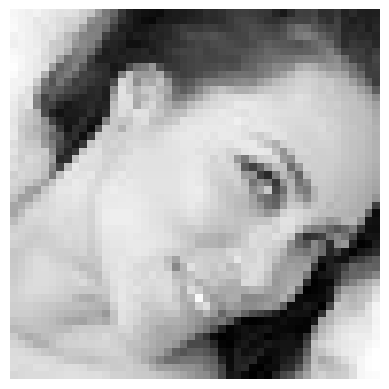

Dimensions of image: 48 x 48 pixels


In [6]:
i = random.randrange(happy_count_2)
image_path = os.path.join(happy_directory, happy_files_2[i])

image = Image.open(image_path)
image.convert('L')

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

# Get and display the dimensions of the image
width, height = image.size
print(f'Dimensions of image: {width} x {height} pixels')

# Preprocessing Image Data

In [ ]:
######################################################################
#             NOT Comp, Method---> have some issues on it            #
######################################################################


#trainData_generator = ImageDataGenerator(rescale = 1./255,
#                                          validation_split=0.2)
# testData_generator = ImageDataGenerator(rescale = 1./255)

# train_generator = trainData_generator.flow_from_directory(
#                       "/content/drive/MyDrive/DL_Tasks_2024/recognize_facial_emotion/Samples/Train_Test_Samples/train",
#                       target_size = (48, 48),
#                       batch_size = 32,
#                       color_mode = "grayscale",
#                       class_mode = "binary",
#                       subset='training')



# validation_generator = trainData_generator.flow_from_directory(
#                       "/content/drive/MyDrive/DL_Tasks_2024/recognize_facial_emotion/Samples/Train_Test_Samples/train",
#                       target_size = (48, 48),
#                       batch_size = 32,
#                       color_mode = "grayscale",
#                       class_mode = "binary",
#                       subset='validation')

# test_generator = testData_generator.flow_from_directory(
#                     "/content/drive/MyDrive/DL_Tasks_2024/recognize_facial_emotion/Samples/Train_Test_Samples/test",
#                     target_size = (48, 48),
#                     batch_size = 32,
#                     color_mode = "grayscale",
#                     class_mode = "binary")

In [7]:
def data_generator_std(root_path):
    img_lst  = []
    class_lst= []
    for dir_level_1 in os.listdir(root_path):
                for file in os.listdir(os.path.join(root_path, dir_level_1)):
                    image_path= os.path.join(root_path, dir_level_1,file)
                    image= cv2.imread(image_path)
                    image= cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #ensure 1D arr
                    image=np.array(image)
                    image = image.astype('float32')
                    image = image / 255.0     #stanzarization
                    img_lst.append(image)
                    if(dir_level_1=="happy"):
                        class_lst.append(1.0)
                    else:
                        class_lst.append(0.0)
    return img_lst, class_lst

In [8]:
train_data ,  train_label  = data_generator_std("/content/drive/MyDrive/DL_Tasks_2024/recognize_facial_emotion/Samples/Train_Test_Samples/train")
test_data  ,  test_label   = data_generator_std("/content/drive/MyDrive/DL_Tasks_2024/recognize_facial_emotion/Samples/Train_Test_Samples/test")

In [9]:

train_data = np.array(train_data)
test_data = np.array( test_data)

train_data = train_data.reshape(train_data.shape[0],train_data.shape[1], train_data.shape[2],1)
test_data = test_data.reshape(test_data.shape[0],test_data.shape[1], test_data.shape[2],1)

print(train_data.shape)
print(test_data.shape)
img_width, img_height, img_num_channels = train_data.shape[1], train_data.shape[2], train_data.shape[3]
input_shape = (img_width, img_height, img_num_channels)

train_label = np.array(train_label,dtype=float)
test_label =  np.array(test_label,dtype=float)


(9660, 48, 48, 1)
(3021, 48, 48, 1)


# shuffeling

In [10]:
shuffled_indices = np.arange(train_data.shape[0])
np.random.shuffle(shuffled_indices)

shuffled_input  = train_data[shuffled_indices]
shuffled_targets = train_label[shuffled_indices]

In [255]:
# sample_count = shuffled_input.shape[0]

# train_sample_count = int(0.9*sample_count)
# validation_sample_count = sample_count-train_sample_count


# train_input = shuffled_input[:train_sample_count]
# train_targets = shuffled_targets[:train_sample_count]

# validation_input = shuffled_input[train_sample_count:]
# validation_targets = shuffled_targets[train_sample_count:]

# show a sample after standarization

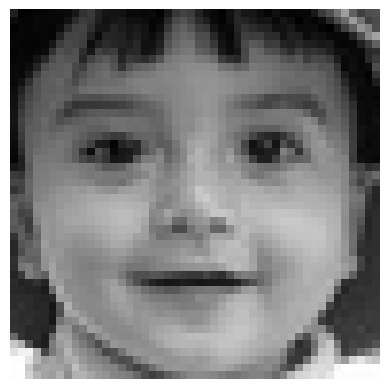

 label : 1.0


In [11]:
i = random.randrange(len(shuffled_targets))
plt.imshow(shuffled_input[i], cmap='gray')
plt.axis('off')
plt.show()

print(" label :",shuffled_targets[i])

# Create the model


In [27]:
model = Sequential()

# Add Convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Flatten the output before the Dense layers
model.add(Flatten())

# Add Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fitting the model

In [29]:
no_epochs = 25
batch_size = 128
validation_split = 0.1
callback = callbacks.EarlyStopping(monitor="val_loss", patience=1)


history = model.fit(shuffled_input, shuffled_targets,
            batch_size=batch_size,
            epochs=no_epochs,
            callbacks=[callback],
            verbose=2,
            validation_split=validation_split
            )

Epoch 1/25
68/68 - 27s - loss: 0.6818 - accuracy: 0.5596 - val_loss: 0.6326 - val_accuracy: 0.6573 - 27s/epoch - 402ms/step
Epoch 2/25
68/68 - 26s - loss: 0.5800 - accuracy: 0.7017 - val_loss: 0.5508 - val_accuracy: 0.7277 - 26s/epoch - 382ms/step
Epoch 3/25
68/68 - 25s - loss: 0.5146 - accuracy: 0.7525 - val_loss: 0.4806 - val_accuracy: 0.7754 - 25s/epoch - 361ms/step
Epoch 4/25
68/68 - 27s - loss: 0.4652 - accuracy: 0.7775 - val_loss: 0.4398 - val_accuracy: 0.7992 - 27s/epoch - 394ms/step
Epoch 5/25
68/68 - 27s - loss: 0.4233 - accuracy: 0.8039 - val_loss: 0.4103 - val_accuracy: 0.8147 - 27s/epoch - 392ms/step
Epoch 6/25
68/68 - 27s - loss: 0.4015 - accuracy: 0.8160 - val_loss: 0.4049 - val_accuracy: 0.8157 - 27s/epoch - 394ms/step
Epoch 7/25
68/68 - 25s - loss: 0.3679 - accuracy: 0.8322 - val_loss: 0.4012 - val_accuracy: 0.8188 - 25s/epoch - 368ms/step
Epoch 8/25
68/68 - 26s - loss: 0.3418 - accuracy: 0.8454 - val_loss: 0.4030 - val_accuracy: 0.8240 - 26s/epoch - 377ms/step


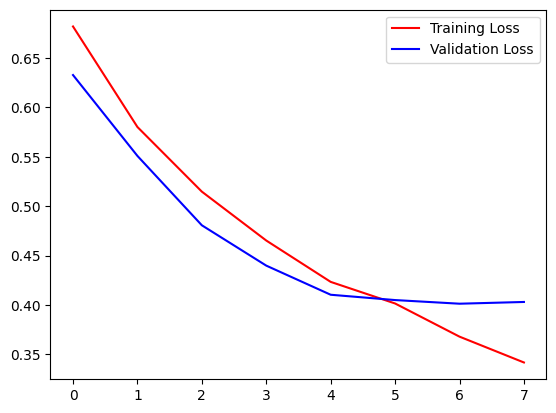

<Figure size 640x480 with 0 Axes>

In [30]:
his_loss     = history.history['loss']
his_val_loss = history.history['val_loss']

real_num_epochs = range(len(his_loss))

plt.plot(real_num_epochs, his_loss, 'red', label='Training Loss')
plt.plot(real_num_epochs, his_val_loss, 'blue', label='Validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()


<Figure size 640x480 with 0 Axes>

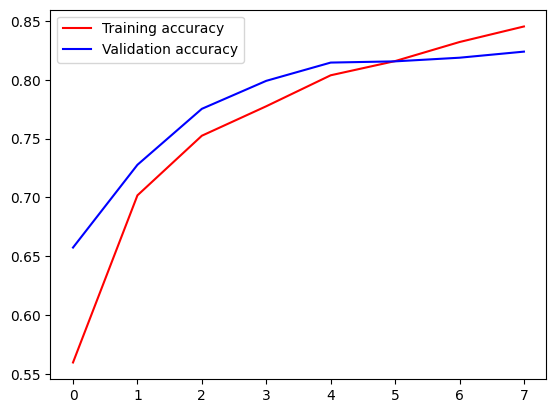

<Figure size 640x480 with 0 Axes>

In [31]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(real_num_epochs, accuracy, 'Red', label='Training accuracy')
plt.plot(real_num_epochs, val_acc, 'blue', label='Validation accuracy')
plt.legend(loc=0)
plt.figure()


# Evaluate the model

In [32]:
test_loss, test_accuracy = model.evaluate(test_data,test_label)

95/95 [==============================] - 3s 32ms/step - loss: 0.4256 - accuracy: 0.8130


# Saving the model

In [33]:
#model.save_weights('./checkpoints/my_checkpoint/')

# Load Model

In [ ]:
model.load_weights('./checkpoints/my_checkpoint/')

# Make predeiction


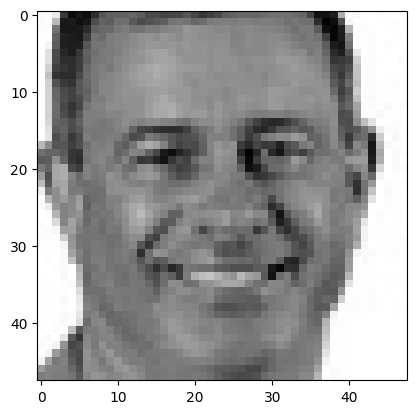

1/1 [==============================] - 0s 41ms/step
pred:  [[0.96928585]]
Actuall:  1.0


In [38]:
idx = random.randrange(len(test_label))
plt.imshow(test_data[idx,:], cmap='gray')
plt.show()

y_pred = model.predict(test_data[idx,:].reshape(1,48,48,1))
print('pred: ', y_pred)
print('Actuall: ', test_label[idx])